In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [61]:
def image_plot(img):
    fig, axes = plt.subplots(1, 1, figsize=(20, 6), sharex=True, sharey=True)
    axes.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Code

In [65]:
from utils.resourceloader import ResourceLoader

from pianovision.keyboard import KeyboardHandler
from pianovision.keyboard.masking import KeyboardMasking

from pianovision.keyboard.data import Keyboard, KeyboardMask
from pianovision.keyboard.func.binarize import keyboardHorizontalDivision, keyboardBlackKeys, keyboardThresholding

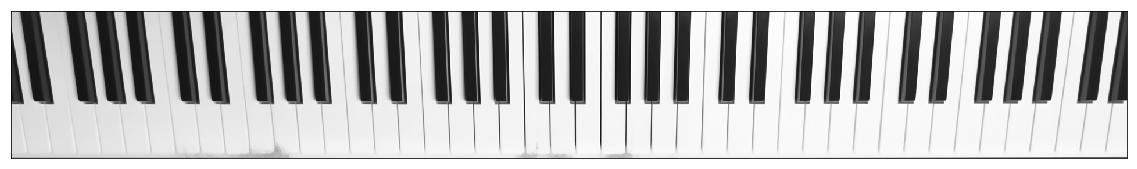

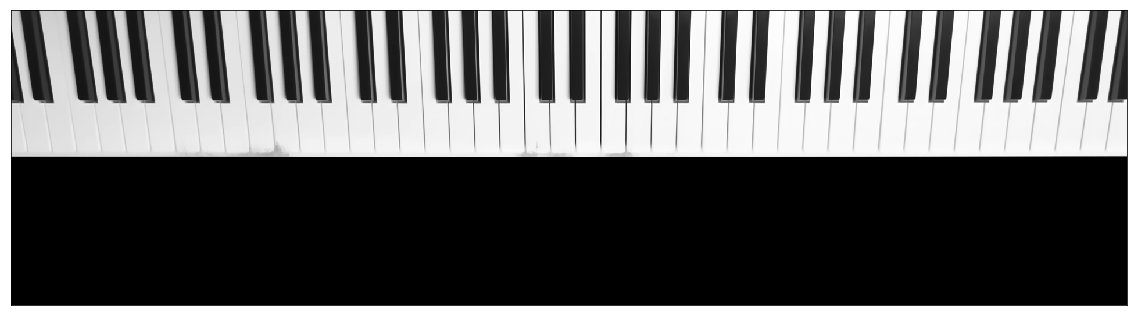

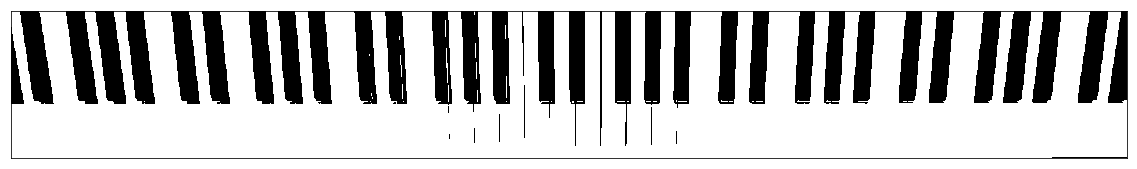

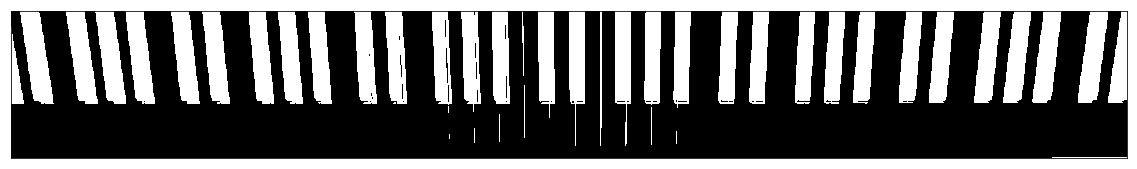

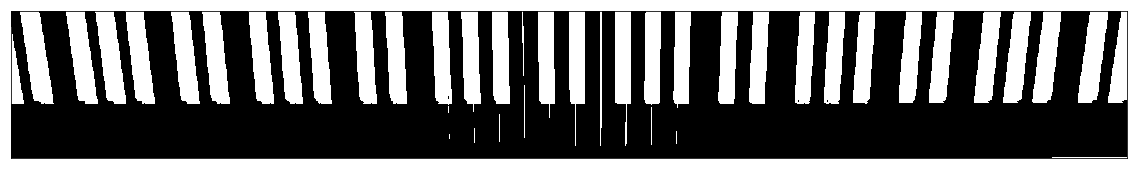

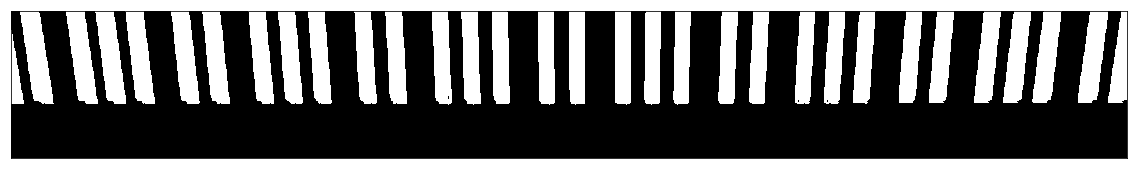

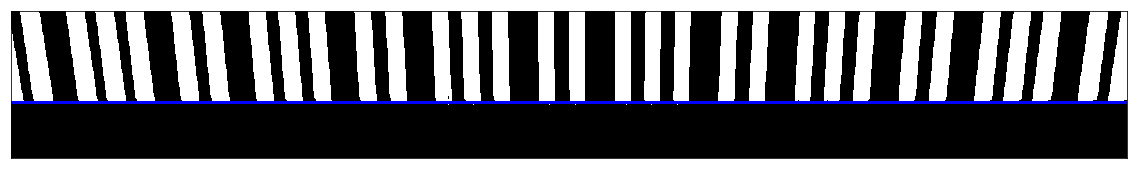

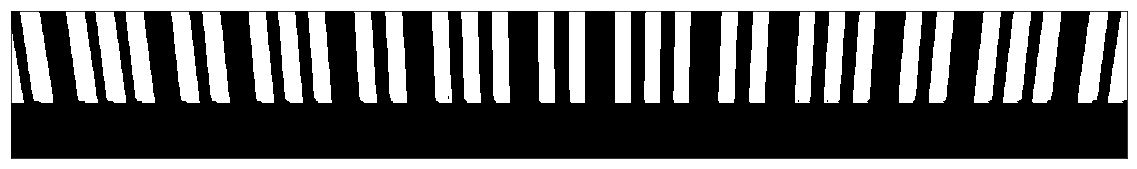

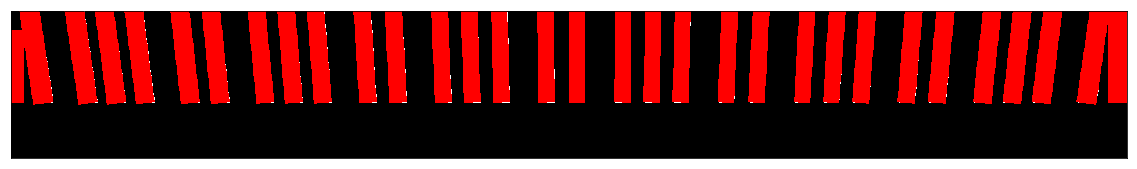

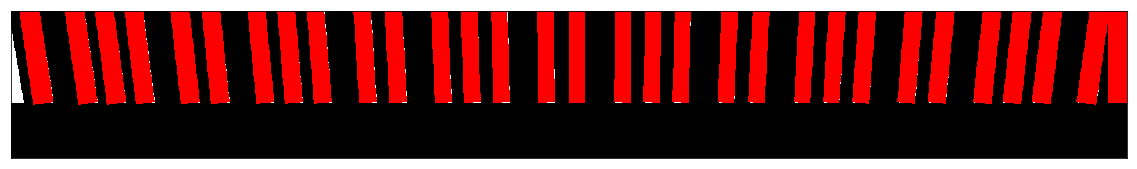

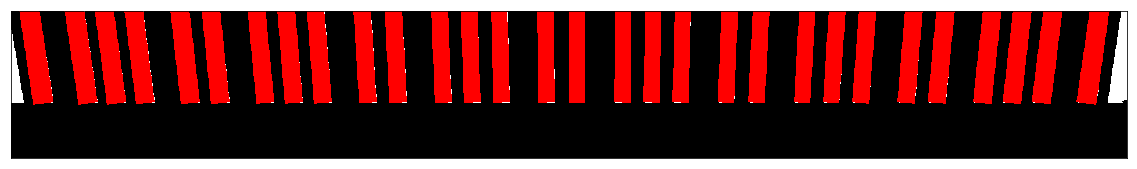

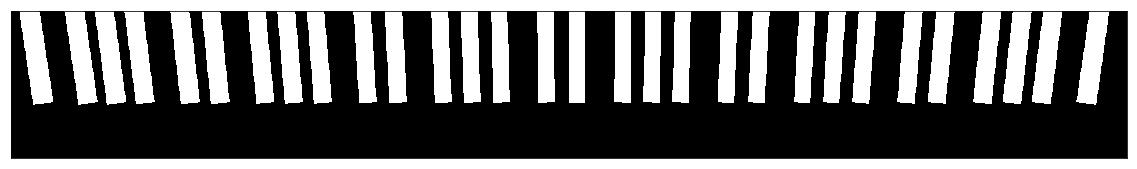

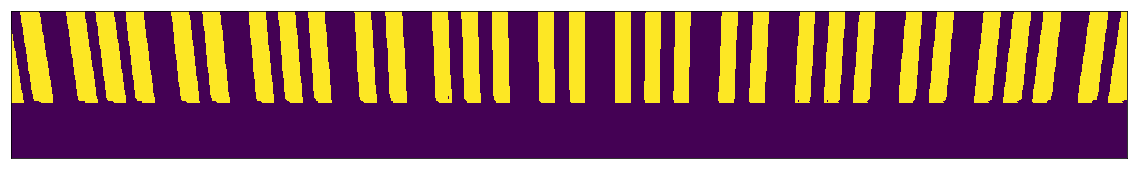

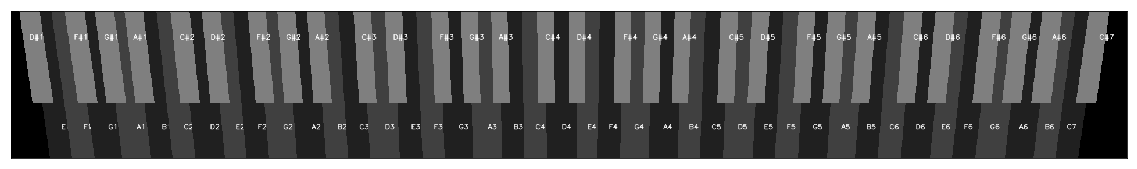

In [66]:
resource = ResourceLoader("flamingo")
kbHandler = KeyboardHandler(resource)
image = kbHandler.keyboard.cropped


gsimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(h, w) = gsimg.shape

# Tunning Otsu method: create a buffer with black pixels
buffer = np.zeros((2 * h, w)).astype('uint8')
buffer[:h, :] = gsimg

# Thresholding with Otsu method
ret, thresh = cv2.threshold(buffer, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh = thresh[:h, :]

image_plot(image)
image_plot(cv2.cvtColor(buffer, cv2.COLOR_GRAY2BGR))
image_plot(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))

thresh = 255 - thresh
image_plot(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))

# Creating a kernel for Morphological Transformations
kernel_size = min(int(image.shape[1] * 0.005), 3)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

# Closing roles inside keys
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
image_plot(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))

# Denoising
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
image_plot(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))

vlimit = keyboardHorizontalDivision(thresh)
mask = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
cv2.line(mask, (0, vlimit), (w-1, vlimit), (0, 0, 255), 3)
image_plot(mask)

thresh[vlimit:] = 0
image_plot(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

median_area = np.median(np.array([cv2.contourArea(cnt) for cnt in contours]))

rectangles = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
rectangles_valid = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
rectangles_quero = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
masking = np.zeros(thresh.shape).astype('uint8')

for cnt in contours:
    # Fit a rectangle on the blob
    rect = cv2.minAreaRect(cnt)
    box = np.intp(cv2.boxPoints(rect))
    
    # --
    cv2.fillPoly(rectangles, [box], 255)
    
    # Ignore small blobs
    blob_area = cv2.contourArea(box)
    if median_area > blob_area and (median_area - blob_area) / median_area > 0.1:
        continue
    cv2.fillPoly(rectangles_valid, [box], 255)
    
    # Create a mask of the blob with original image shape
    blob = np.zeros(thresh.shape).astype(int)
    cv2.fillPoly(blob, [cnt], 1)

    # Create a mask of the rectangle with original image shape
    rect = np.zeros(thresh.shape).astype(int)
    cv2.fillPoly(rect, [box], 1)

    # Compute a error based in difference between blob mask and rectangle mask
    error = float((rect * (1 - blob)).sum())

    # Ignore wrong rectangles
    if error / blob.sum() > 0.5:
        continue
    cv2.fillPoly(rectangles_quero, [box], 255)
    cv2.fillPoly(masking, [box], 255)

image_plot(rectangles)
image_plot(rectangles_valid)
image_plot(rectangles_quero)
image_plot(cv2.cvtColor(masking, cv2.COLOR_GRAY2BGR))
image_plot(kbHandler.keyboard.mask.thresh)

image_plot(cv2.cvtColor(kbHandler.keyboard.mask.createMask(visual=True), cv2.COLOR_GRAY2BGR))